<a href="https://colab.research.google.com/github/mayankcodezzz/AnimatioExamples-stepperCounter-loadingRippleCircleGenerator-waterFlowAnimationWave-/blob/main/prob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

100%|██████████| 170M/170M [00:02<00:00, 69.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/20 | ReLU | Loss: 1.5549 | Acc: 0.5419
Epoch 1/20 | LeakyReLU | Loss: 1.5418 | Acc: 0.5302
Epoch 1/20 | Tanh | Loss: 1.4977 | Acc: 0.5436
Epoch 1/20 | Probabilistic | Loss: 1.3048 | Acc: 0.5325
Epoch 2/20 | ReLU | Loss: 1.2240 | Acc: 0.5853
Epoch 2/20 | LeakyReLU | Loss: 1.2216 | Acc: 0.5956
Epoch 2/20 | Tanh | Loss: 1.1674 | Acc: 0.6114
Epoch 2/20 | Probabilistic | Loss: 0.9657 | Acc: 0.5907
Epoch 3/20 | ReLU | Loss: 1.0901 | Acc: 0.6205
Epoch 3/20 | LeakyReLU | Loss: 1.0832 | Acc: 0.6230
Epoch 3/20 | Tanh | Loss: 1.0220 | Acc: 0.6497
Epoch 3/20 | Probabilistic | Loss: 0.8020 | Acc: 0.6333
Epoch 4/20 | ReLU | Loss: 1.0005 | Acc: 0.6524
Epoch 4/20 | LeakyReLU | Loss: 0.9855 | Acc: 0.6502
Epoch 4/20 | Tanh | Loss: 0.9239 | Acc: 0.6675
Epoch 4/20 | Probabilistic | Loss: 0.6803 | Acc: 0.6424
Epoch 5/20 | ReLU | Loss: 0.9266 | Acc: 0.6662
Epoch 5/20 | LeakyReLU | Loss: 0.9087 | Acc: 0.6616
Epoc

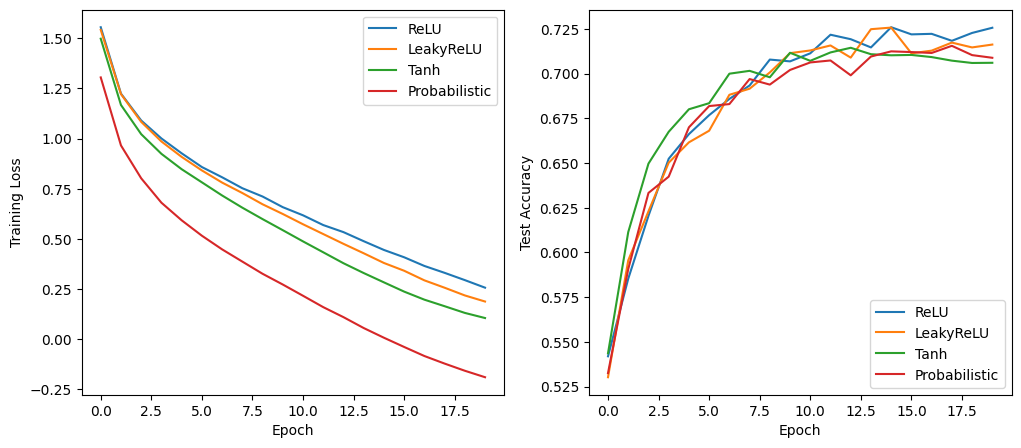

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
learning_rate = 3e-4
epochs = 20
temperature_initial = 1.0
temperature_decay = 0.01
entropy_coeff = 0.1

# Load dataset (e.g., CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

# Define probabilistic activation layer
class ProbActivation(nn.Module):
    def __init__(self, num_activations=3):
        super().__init__()
        self.num_activations = num_activations
        self.logits = nn.Parameter(torch.randn(num_activations))  # Learnable logits
        self.temperature = temperature_initial

        # Define candidate activation functions
        self.activations = nn.ModuleList([
            nn.ReLU(),
            nn.LeakyReLU(0.01),
            nn.Tanh()
        ])

    def forward(self, x):
        # Sample activation probabilities using Gumbel-Softmax
        probabilities = torch.softmax(self.logits / self.temperature, dim=0)

        # Compute weighted sum of activations
        output = 0.0
        for i in range(self.num_activations):
            output += probabilities[i] * self.activations[i](x)

        return output

# Define neural network architectures
class FixedActivationNet(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            activation_fn(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            activation_fn(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            activation_fn(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

class ProbActivationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            ProbActivation(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            ProbActivation(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            ProbActivation(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize models
models = {
    'ReLU': FixedActivationNet(nn.ReLU).to(device),
    'LeakyReLU': FixedActivationNet(nn.LeakyReLU).to(device),
    'Tanh': FixedActivationNet(nn.Tanh).to(device),
    'Probabilistic': ProbActivationNet().to(device)
}

# Loss and optimizers
criterion = nn.CrossEntropyLoss()
optimizers = {
    name: optim.Adam(model.parameters(), lr=learning_rate)
    for name, model in models.items()
}

# Training loop
def train(model, optimizer, train_loader, epoch):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Add entropy regularization for probabilistic model
        if isinstance(model, ProbActivationNet):
            entropy_loss = 0.0
            for module in model.modules():
                if isinstance(module, ProbActivation):
                    probs = torch.softmax(module.logits / module.temperature, dim=0)
                    entropy = -torch.sum(probs * torch.log(probs + 1e-10))
                    entropy_loss += entropy
            loss -= entropy_coeff * entropy_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Anneal temperature for probabilistic model
    if isinstance(model, ProbActivationNet):
        for module in model.modules():
            if isinstance(module, ProbActivation):
                module.temperature = temperature_initial * np.exp(-temperature_decay * epoch)

    return total_loss / len(train_loader)

# Evaluation
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Train and evaluate all models
results = {name: {'train_loss': [], 'test_acc': []} for name in models}
for epoch in range(epochs):
    for name, model in models.items():
        train_loss = train(model, optimizers[name], train_loader, epoch)
        test_acc = evaluate(model, test_loader)
        results[name]['train_loss'].append(train_loss)
        results[name]['test_acc'].append(test_acc)
        print(f'Epoch {epoch+1}/{epochs} | {name} | Loss: {train_loss:.4f} | Acc: {test_acc:.4f}')

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name in models:
    plt.plot(results[name]['train_loss'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
for name in models:
    plt.plot(results[name]['test_acc'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

# Print final probabilities for probabilistic model
prob_model = models['Probabilistic']
for name, module in prob_model.named_modules():
    if isinstance(module, ProbActivation):
        probs = torch.softmax(module.logits / module.temperature, dim=0).detach().cpu().numpy()
        print(f"Layer {name} probabilities: ReLU={probs[0]:.3f}, LeakyReLU={probs[1]:.3f}, Tanh={probs[2]:.3f}")